10773it [2:39:58,  1.12it/s]
100%|██████████| 1348/1348 [19:31<00:00,  1.15it/s] 


step 0: train loss:  0.6842, val loss: 0.6737
step 0: train accuracy:  53.30%, val accuracy: 58.66%


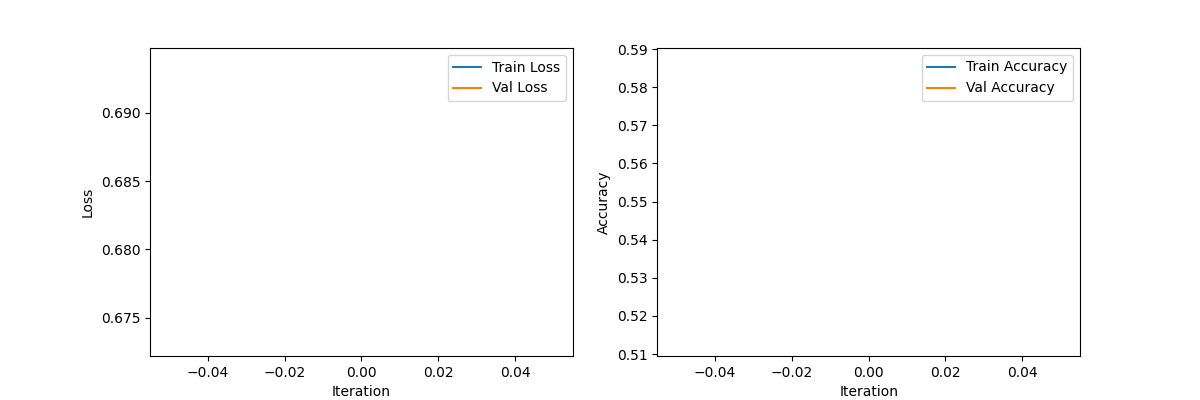

Iter [1/100] - Elapsed Time: 9598.32s  Remaining Time: [959832.42]


10773it [2:29:09,  1.20it/s]

Iter [2/100] - Elapsed Time: 19720.18s  Remaining Time: [976149.10]



10773it [2:29:27,  1.20it/s]

Iter [3/100] - Elapsed Time: 28688.17s  Remaining Time: [937146.93]



10773it [2:30:33,  1.19it/s]

Iter [4/100] - Elapsed Time: 37721.50s  Remaining Time: [914746.45]



10773it [2:31:14,  1.19it/s]

Iter [5/100] - Elapsed Time: 46796.15s  Remaining Time: [898486.08]



10773it [2:31:44,  1.18it/s]
100%|██████████| 1348/1348 [19:46<00:00,  1.14it/s]


step 5: train loss:  0.5699, val loss: 0.5689
step 5: train accuracy:  72.58%, val accuracy: 72.94%


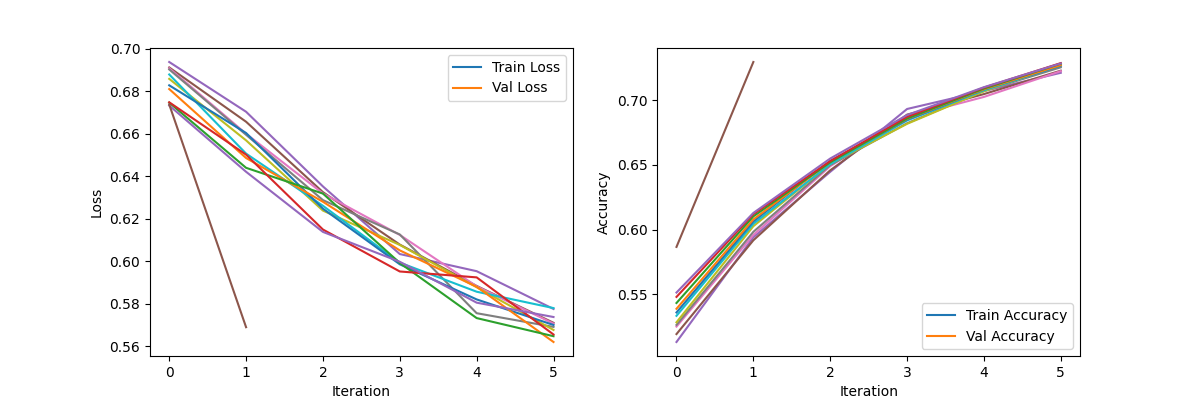

Iter [6/100] - Elapsed Time: 55900.95s  Remaining Time: [885098.44]


10773it [2:31:40,  1.18it/s]

Iter [7/100] - Elapsed Time: 66188.18s  Remaining Time: [888812.72]



10773it [2:37:02,  1.14it/s]

Iter [8/100] - Elapsed Time: 75611.27s  Remaining Time: [878980.98]



10773it [2:35:32,  1.15it/s]

Iter [9/100] - Elapsed Time: 84944.30s  Remaining Time: [868319.53]



10773it [2:35:30,  1.15it/s]

Iter [10/100] - Elapsed Time: 94275.09s  Remaining Time: [857903.34]



10773it [2:33:11,  1.17it/s]
100%|██████████| 1348/1348 [20:05<00:00,  1.12it/s]


step 10: train loss:  0.5209, val loss: 0.5416
step 10: train accuracy:  78.67%, val accuracy: 76.11%


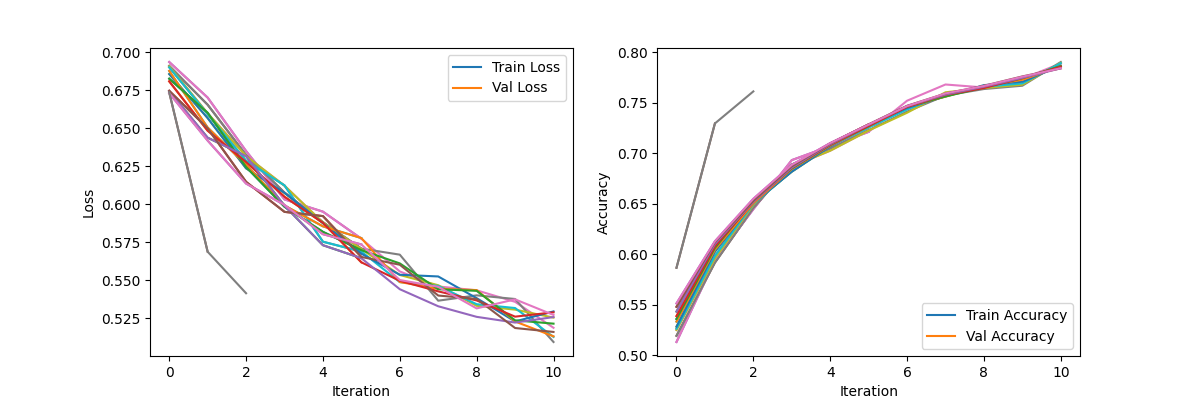

Iter [11/100] - Elapsed Time: 103467.13s  Remaining Time: [846549.27]


10773it [2:33:44,  1.17it/s]

Iter [12/100] - Elapsed Time: 113898.11s  Remaining Time: [844744.31]



10773it [2:33:26,  1.17it/s]

Iter [13/100] - Elapsed Time: 123104.37s  Remaining Time: [833321.89]



10773it [2:34:16,  1.16it/s]

Iter [14/100] - Elapsed Time: 132361.47s  Remaining Time: [822532.02]



10773it [2:33:45,  1.17it/s]

Iter [15/100] - Elapsed Time: 141587.52s  Remaining Time: [811768.45]



8248it [2:08:39,  1.16s/it]

In [1]:
'''using torchvision for dataloading'''
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from psutil import cpu_count
from torchvision import transforms
from torch.utils.data import DataLoader
from dataloader import PicklebotDataset, custom_collate
from mobilenet import MobileNetLarge2D, MobileNetSmall2D, MobileNetSmall3D,MobileNetLarge3D, MobileNetTiny3D 
from helpers import calculate_accuracy, average_for_plotting

%matplotlib widget


device = 'cuda' if torch.cuda.is_available() else 'cpu'

#hyperparameters
learning_rate = 3e-4 #the paper quotes rmsprop with 0.1 lr, but we have a tiny batch size, and are using AdamW
batch_size = 4 #the paper quotes 128 images/chip, but with video we have to change this
max_iters = 100
eval_interval = 5 
weight_decay = 0.0005
momentum = 0.9
eps = np.sqrt(0.002) #From the pytorch blog post, "a reasonable approximation can be taken with the formula PyTorch_eps = sqrt(TF_eps)."
std = (0.2104, 0.1986, 0.1829)
mean = (0.3939, 0.3817, 0.3314)
use_autocast = False
compile = False

#video paths
train_video_paths = '/workspace/picklebotdataset/train'
val_video_paths = '/workspace/picklebotdataset/val'

#annotations paths
train_annotations_file = '/home/henry/Documents/PythonProjects/picklebotdataset/train_labels.csv'
val_annotations_file = '/home/henry/Documents/PythonProjects/picklebotdataset/val_labels.csv'

#video paths
train_video_paths = '/home/henry/Documents/PythonProjects/picklebotdataset/train_all_together'
val_video_paths = '/home/henry/Documents/PythonProjects/picklebotdataset/val_all_together'

#establish our normalization using transforms, 
#note that we are doing this in our dataloader as opposed to in the training loop like with dali
transform = transforms.Normalize(mean,std)

#dataset     
train_dataset = PicklebotDataset(train_annotations_file,train_video_paths,transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,collate_fn=custom_collate,num_workers=cpu_count()/2)
val_dataset = PicklebotDataset(val_annotations_file,val_video_paths,transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True,collate_fn=custom_collate,num_workers=cpu_count()/2)

#define model, initialize weights 
model = MobileNetSmall3D()
model.initialize_weights()
model = model.to(device)

#for multi-gpu
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# optimizer, loss function
# optimizer = optim.RMSprop(params=model.parameters(),lr=learning_rate,weight_decay=weight_decay,momentum=momentum,eps=eps) #starting with AdamW for now. 
optimizer = optim.AdamW(params=model.parameters(),lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
if use_autocast:
    scaler = GradScaler()
model_name = 'mobilenetsmall_3D_cloud' 
# model.load_state_dict(torch.load(f'{model_name}.pth')) #if applicable, load the model from the last checkpoint

if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model)  # requires PyTorch 2 and a modern gpu, these lines were lifted from karpathy
    print("compilation complete!")


#estimate loss using the val set, and calculate accuracy
@torch.no_grad()
def estimate_loss():
    #evaluate the model
    model.eval()
    val_losses = [] 
    val_correct = 0
    val_samples = 0

    #calculate the loss
    for val_features,val_labels in tqdm(val_loader):
        val_features = val_features.to(device)
        val_labels = val_labels.to(torch.int64) #waiting to move to device until after forward pass, idk if this matters
        # val_labels = val_labels.expand(val_features.shape[2]) #this is only for our lstm T -> batch size, a lame hack    
        val_outputs = model(val_features)

        val_loss = criterion(val_outputs,val_labels.to(device))
        val_losses.append(val_loss.item())
        
        val_correct += calculate_accuracy(val_outputs,val_labels)
        val_samples += len(val_labels)

    avg_val_loss = np.mean(val_losses)
    val_accuracy = val_correct / val_samples
    return avg_val_loss, val_accuracy

#try except block so we can manually early stop while saving the model
#training loop
start_time = time.time()
train_losses = []
train_percent = []
val_losses = []
val_percent = []


#plot losses
plt.ion()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.legend()

#plot accuracy
ax2.plot(train_percent, label='Train Accuracy')
ax2.plot(val_percent, label='Val Accuracy')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy')
ax2.legend()

def main():
    try:
        for iter in range(max_iters):
            
            model.train()
            train_correct = 0
            train_samples = 0
            batch_loss_list = []
            batch_percent_list = []

            #forward pass
            for batch_idx, (features,labels) in tqdm(enumerate(train_loader)):
                labels = labels.to(torch.int64)
                features = features.to(device)
                # labels = labels.expand(features.shape[2]) #this is only for our lstm T -> batch size, a lame hack
                
                #zero the gradients
                optimizer.zero_grad(set_to_none=True)
                
                if use_autocast:    
                    with autocast():
                        outputs = model(features)
                        loss = criterion(outputs,labels.to(device))
                    
                    #backprop & update weights

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                else:
                    outputs = model(features)
                    loss = criterion(outputs,labels.to(device))

                    #backprop & update weights
                    loss.backward()
                    optimizer.step()
                
                batch_loss_list.append(loss.item()) #append the loss of the batch to our list to be averaged and plotted later, this is dataset size / batch size long
                batch_correct = calculate_accuracy(outputs,labels) #number of correct predictions in the batch
                train_correct += batch_correct #this is the total number of correct predictions so far
                train_samples += len(labels) #this is the total number of samples so far
                batch_percent_list.append(train_correct/train_samples)

            train_losses.append(average_for_plotting(batch_loss_list)) #train losses is a list of tensors 
            train_percent.append(average_for_plotting(batch_percent_list))
            elapsed = time.time() - start_time
            remaining_iters = max_iters - iter
            avg_time_per_iter = elapsed / (iter + 1)
            estimated_remaining_time = remaining_iters * avg_time_per_iter

            if iter % eval_interval == 0 or iter == max_iters - 1:
                            
                #evaluate the model
                val_loss, val_accuracy = estimate_loss()
            
                val_losses.append(val_loss) #average loss of the val dataset, this is a scalar
                val_percent.append(val_accuracy) #percent of correct predictions in the val set, this is a scalar


                print(f"step {iter}: train loss:  {train_losses[-1].mean().item():.4f}, val loss: {val_losses[-1]:.4f}") #report the average loss of the batch
                print(f"step {iter}: train accuracy:  {(train_percent[-1].mean().item())*100:.2f}%, val accuracy: {val_percent[-1]*100:.2f}%")

                # #plot the losses
                ax1.plot(train_losses, label='Train Loss')
                ax1.plot(val_losses, label='Val Loss')

                #plot the accuracy
                ax2.plot(train_percent, label='Train Accuracy')
                ax2.plot(val_percent, label='Val Accuracy')


                fig.canvas.draw()
                fig.canvas.flush_events()
                plt.pause(0.001)

            tqdm.write(f"Iter [{iter+1}/{max_iters}] - Elapsed Time: {elapsed:.2f}s  Remaining Time: [{estimated_remaining_time:.2f}]")
            if iter == max_iters -1:
                print("Training completed:") 
                print(f"Final train loss: {train_losses[-1].mean().item():.4f},")
                print(f"Final val loss: {val_losses[-1]:.4f}, ")
                print(f"Final train accuracy: {(train_percent[-1].mean().item())*100:.2f}%, ")
                print(f"Final val accuracy: {val_percent[-1]*100:.2f}%") 
                
    except KeyboardInterrupt:
        print(f"Keyboard interrupt,\nFinal train loss: {train_losses[-1].mean().item():.4f}, ")
        print(f"Final val loss: {val_losses[-1]:.4f}, ")
        print(f"Final train accuracy: {(train_percent[-1].mean().item())*100:.2f}%, ")
        print(f"Final val accuracy: {val_percent[-1]*100:.2f}%")

    finally:
        torch.save(model.state_dict(), f'{model_name}.pth')
        with open(f'{model_name}_train_losses.npy', 'wb') as f:
            np.save(f, np.array(train_losses))
        with open(f'{model_name}_val_losses.npy', 'wb') as f:
            np.save(f, np.array(val_losses))
        with open(f'{model_name}_train_percent.npy', 'wb') as f:
            np.save(f, np.array(train_percent))
        with open(f'{model_name}_val_percent.npy', 'wb') as f:
            np.save(f, np.array(val_percent))
        print(f"Model saved!") 
    plt.ioff()

if __name__ == "__main__":
    import cProfile
    cProfile.run(main())

In [ ]:
'''This version of the program uses Nvidia Dali to load data, not torchvision.io.read_video,
   It should be substantially faster, especially with multiple gpus, perhaps a good setup 
   would be one to load the videos, one to run the training loop? Perhaps not as I learned more about it.

    Eventually, this and the other version in this notebook should be merged into one notebook, with a flag to choose which to use.
   
'''
import os
import torch
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from torchvision.io import write_video
from nvidia.dali.plugin.pytorch import DALIClassificationIterator, LastBatchPolicy
from tqdm import tqdm
from psutil import cpu_count
from mobilenet import MobileNetLarge2D, MobileNetSmall2D, MobileNetSmall3D, MobileNetLarge3D, MobileNetTiny3D
from helpers import calculate_accuracy, video_pipeline, average_for_plotting

%matplotlib widget

'''
Our mean is ([0.3939, 0.3817, 0.3314])
Our std is ([0.2104, 0.1986, 0.1829])
'''



'''Strikes are 0, balls 1.'''

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#hyperparameters
learning_rate = 3e-4 #the paper quotes rmsprop with 0.1 lr, but we have a tiny batch size, and are using AdamW
batch_size = 4 #the paper quotes 128 images/chip, but with video we have to change this
max_iters = 300
eval_interval = 2
weight_decay = 0.0005
momentum = 0.9
eps = np.sqrt(0.002) #From the pytorch blog post, "a reasonable approximation can be taken with the formula PyTorch_eps = sqrt(TF_eps)."
std = torch.tensor([0.2104, 0.1986, 0.1829])[None,None,None,:]
mean = torch.tensor([0.3539, 0.3817, 0.3314])[None,None,None,:]
use_autocast = True
compile = False

#information for the dali pipeline
sequence_length = 199 #longest videos in our dataset (changed to smaller number for testing)
initial_prefetch_size = 20

#video paths
train_video_paths = '/workspace/picklebotdataset/train'
val_video_paths = '/workspace/picklebotdataset/val'

train_video_paths = '/home/hankhome/Documents/PythonProjects/picklebotdataset/train'
val_video_paths = '/home/hankhome/Documents/PythonProjects/picklebotdataset/val'
num_train_videos = len(os.listdir(train_video_paths + '/' + 'balls')) + len(os.listdir(train_video_paths + '/' + 'strikes'))
num_val_videos = len(os.listdir(val_video_paths + '/' + 'balls')) + len(os.listdir(val_video_paths + '/' + 'strikes'))

#define our model, initialize weights
model = MobileNetSmall3D()
# model.initialize_weights()
model = model.to(device)

#for multi-gpu setups 
#may want to revisit this and choose which device we use for loading with dali, and which to use for training the net.
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

#define our optimizer
#optimizer = optim.RMSprop(params=model.parameters(),lr=learning_rate,weight_decay=weight_decay,momentum=momentum,eps=eps) #starting with AdamW for now. 
optimizer = optim.AdamW(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss() 
scaler = GradScaler()
model_name = 'mobilenetsmall_3D_cloud' 
# model.load_state_dict(torch.load(f'{model_name}.pth')) #if applicable, load the model from the last checkpoint


if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model)  # requires PyTorch 2 and a modern gpu, these lines were lifted from karpathy
    print("compilation complete!")

#estimate_loss using validation set, we should refactor this.
@torch.no_grad()
def estimate_loss():
    #evaluate the model
    model.eval()
    val_losses = []
    val_correct = 0
    val_samples = 0

    #calculate the loss
    for _,val_features in tqdm(enumerate(val_loader)):
        val_labels = (val_features[0]['label']).view(-1).long() #need this as a (batch_size,) tensor
        val_features = val_features[0]['data']/255
        # val_features = (val_features-mean.to(device))/std.to(device) #normalize
        val_features = val_features.permute(0,-1,1,2,3) 
        # val_labels = val_labels.expand(val_features.shape[2]) #this is only for our lstm T -> batch size, a lame hack

        val_outputs = model(val_features)
        
        val_loss = criterion(val_outputs,val_labels)
        
        val_losses.append(val_loss.item())  
        
        val_correct += calculate_accuracy(val_outputs,val_labels) #get number of correct
        val_samples += len(labels) #this is the total number of samples so far

    avg_val_loss = np.mean(val_losses)
    val_accuracy = val_correct / val_samples
    return avg_val_loss, val_accuracy


#initialize lists for plotting
start_time = time.time()
train_losses = torch.tensor([])
train_percent = torch.tensor([])
val_losses = []
val_percent = []

#plot losses
plt.ion()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
fig.show()
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.legend()

#plot accuracy
ax2.plot(train_percent, label='Train Accuracy')
ax2.plot(val_percent, label='Val Accuracy')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy')
ax2.legend()

#build our pipelines
train_pipe = video_pipeline(batch_size=batch_size, num_threads=cpu_count(), device_id=0, file_root=train_video_paths,
                            sequence_length=sequence_length,initial_prefetch_size=initial_prefetch_size,mean=mean,std=std)
val_pipe = video_pipeline(batch_size=batch_size, num_threads=cpu_count(), device_id=0, file_root=val_video_paths,
                          sequence_length=sequence_length,initial_prefetch_size=initial_prefetch_size,mean=mean,std=std)

train_pipe.build()
val_pipe.build()


train_loader = DALIClassificationIterator(train_pipe, auto_reset=True,last_batch_policy=LastBatchPolicy.PARTIAL, size=num_train_videos)
val_loader = DALIClassificationIterator(train_pipe, auto_reset=True,last_batch_policy=LastBatchPolicy.PARTIAL, size=num_train_videos)

try:
    for iter in range(max_iters):
        
        model.train()
        train_correct = 0
        train_samples = 0
        batch_loss_list = [] #want to overwrite this each epoch
        batch_percent_list = []

        #forward pass
        for batch_idx, features in tqdm(enumerate(train_loader)):
            
            labels = (features[0]['label']).view(-1).long() #need this as a (batch_size,) tensor in int64
            features = features[0]['data']/255 #i think it makes sense to overwrite features to save precious gpu memory
            # features = (features-mean.to(device))/std.to(device) #normalize
            features = features.permute(0,-1,1,2,3) #reshape for our 3D convolutions
            # labels = labels.expand(features.shape[2]) #this is only for our lstm T -> batch size, a lame hack
            
            #zero the gradients
            optimizer.zero_grad(set_to_none=True)
            
            if use_autocast:    
                with autocast():
                    outputs = model(features)
                    loss = criterion(outputs,labels)
                
                #backprop & update weights

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            else:
                outputs = model(features)
                loss = criterion(outputs,labels)

                #backprop & update weights
                loss.backward()
                optimizer.step()

            batch_loss_list.append(loss.item()) #append the loss of the batch to our list to be averaged and plotted later, this is dataset size / batch size long
            batch_correct = calculate_accuracy(outputs,labels) #number of correct predictions in the batch
            train_correct += batch_correct #this is the total number of correct predictions so far
            train_samples += len(labels) #this is the total number of samples so far
            batch_percent_list.append(train_correct/train_samples)

        train_losses = torch.cat((train_losses,average_for_plotting(batch_loss_list))) #train losses is a tensor
        train_percent = torch.cat((train_percent,average_for_plotting(batch_percent_list))) #train percent is a tensor
        elapsed = time.time() - start_time
        remaining_iters = max_iters - iter
        avg_time_per_iter = elapsed / (iter + 1)
        estimated_remaining_time = remaining_iters * avg_time_per_iter

        if iter % eval_interval == 0 or iter == max_iters - 1:
                        
            #evaluate the model
            val_loss, val_accuracy = estimate_loss()
            print(len(batch_loss_list))
            val_losses.append(val_loss) #average loss of the val dataset, this is a scalar
            val_percent.append(val_accuracy) #percent of correct predictions in the val set, this is a scalar


            print(f"step {iter}: train loss:  {train_losses[-1].mean().item():.4f}, val loss: {val_losses[-1]:.4f}") #report the average loss of the batch
            print(f"step {iter}: train accuracy:  {(train_percent[-1].mean().item())*100:.2f}%, val accuracy: {val_percent[-1]*100:.2f}%")

            # #plot the losses
            ax1.plot(train_losses, label='Train Loss')
            ax1.plot(val_losses, label='Val Loss')

            #plot the accuracy
            ax2.plot(train_percent, label='Train Accuracy')
            ax2.plot(val_percent, label='Val Accuracy')


            fig.canvas.draw()
            fig.canvas.flush_events()
            plt.pause(1)
            time.sleep(1)

        tqdm.write(f"Iter [{iter+1}/{max_iters}] - Elapsed Time: {elapsed:.2f}s  Remaining Time: [{estimated_remaining_time:.2f}]")
        if iter == max_iters -1:
            print("Training completed:") 
            print(f"Final train loss: {train_losses[-1].mean().item():.4f},")
            print(f"Final val loss: {val_losses[-1]:.4f}, ")
            print(f"Final train accuracy: {(train_percent[-1].mean().item())*100:.2f}%, ")
            print(f"Final val accuracy: {val_percent[-1]*100:.2f}%") 
            
except KeyboardInterrupt:
    print(f"Keyboard interrupt,\nFinal train loss: {train_losses[-1].mean().item():.4f}, ")
    print(f"Final val loss: {val_losses[-1]:.4f}, ")
    print(f"Final train accuracy: {(train_percent[-1].mean().item())*100:.2f}%, ")
    print(f"Final val accuracy: {val_percent[-1]*100:.2f}%")

finally:
    torch.save(model.state_dict(), f'{model_name}.pth')
    with open(f'{model_name}_train_losses.npy', 'wb') as f:
        np.save(f, np.array(train_losses))
    with open(f'{model_name}_val_losses.npy', 'wb') as f:
        np.save(f, np.array(val_losses))
    with open(f'{model_name}_train_percent.npy', 'wb') as f:
        np.save(f, np.array(train_percent))
    with open(f'{model_name}_val_percent.npy', 'wb') as f:
        np.save(f, np.array(val_percent))
    print(f"Model saved!") 
plt.ioff()